In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import pandas

from shoebox.firwin_torch import firwin_torch

## Data Loading

In [2]:
# load generated data
rir_np = np.load("./rirData/ism_280_multi_low.npy", allow_pickle=False)
rir_np.shape

(280, 96009)

In [3]:
# load real rir data
rir_real = np.load("real_room_ir.npy", allow_pickle=False)
rir_real.shape

(166, 96000)

## Rir Generators

In [4]:
eps=1e-30#2.2204e-30

In [5]:
def analytic_damping_density(sigma, K, V, device='cpu'):
    ###
    # sigma is also carrying grad
    ###
    Kx, Ky, Kz = K
    # if Kx.requires_grad : Kx.register_hook(lambda x : print("Kx (in analytic): ", Kx.grad_fn,Kx.data, torch.isnan(x)))
    eps=2.2204e-20

    A = -(Kx**2 + Ky**2 + Kz**2)
    # if A.requires_grad : A.register_hook(lambda x : print("A: ",x, A.grad_fn,A.data, torch.any(torch.isnan(x))))
    B = 2 * sigma * Kz
    # if B.requires_grad : B.register_hook(lambda x : print("B: ",x[:10], B.grad_fn,B.data[:10],torch.any(torch.isnan(x))))
    C = Kx**2 + Ky**2 - sigma**2
    # if C.requires_grad : C.register_hook(lambda x : print("C: ",x[:10], C.grad_fn,C.data[:10],torch.any(torch.isnan(x))))
    tmpy = (B**2 - 4 * A * C)
    # remove negative numbers
    #delta = torch.Tensor(np.real([cmath.sqrt(it) for it in tmpy])) #torch.sqrt(B**2 - 4 * A * C)
    delta = torch.sqrt(torch.clamp(tmpy, min=torch.tensor(eps).to(device=device)) )
    # if delta.requires_grad : delta.register_hook(lambda x : print("delta: ",x[:10], delta.grad_fn,delta.data[:10],torch.any(torch.isnan(x))))

    a0 = -torch.sqrt(Kx**2 + Ky**2)
    a1 = Kx
    a2 = Ky
    b = Kz
    c = sigma

    function_p = lambda a: torch.clip((torch.Tensor([[1],[-1]]).to(device=device)*torch.acos(torch.clamp((-c / torch.sqrt(a**2 + b**2)), min=torch.tensor(-0.99999).to(device=device), max=torch.tensor(0.99999).to(device=device)))) - torch.atan(-a/b), min=0, max=torch.pi/2)

    p0 = function_p(a0) #func_p(a0, b , c)
    p1 = function_p(a1) #func_p(a1, b , c)
    p2 = function_p(a2) #func_p(a2, b , c)
    
    function_F = lambda phi: -(1/torch.sqrt(-A)) * torch.asin(torch.clamp(((2 * A * torch.cos(phi) + B)/ (delta + eps)), min=torch.tensor(-0.99999).to(device=device), max=torch.tensor(0.99999).to(device=device)))
    Fint = lambda p_up, p_low:(function_F(p_up) - function_F(p_low))
 
    H0 = Fint(p0[1, :], p0[0, :])
    H1 = Fint(p1[1, :], p1[0, :])
    H2 = Fint(p2[1, :], p2[0, :])
    # if H1.requires_grad : H1.register_hook(lambda x : print("H1: ",x[:10], H1.grad_fn, H1.data[:10], torch.any(torch.isnan(x))))

    H = (8 / (4 * torch.pi * V)) * (2 * H0 - H1 - H2)

    # only as return values
    p = torch.stack([p0, p1, p2])

    return H, p

In [90]:
def generate_stochastic_rir(Kx, Ky, Kz, V=torch.prod(torch.tensor([3,4,5])), fs=48000, c=343, max_time=2.0, use_pressure_source=False, device='cpu'):
#(max_time, beta, L, c, fs, use_pressure_source=False):
    # Predefine L 
    #eps=2.2204e-50
    # 
    # max_time = 2.0
    # fs = 48000
    c = 343
    # if Ky.requires_grad : Ky.register_hook(lambda x : print("Ky: ", Ky.grad_fn,Ky.data, torch.isnan(x)))
    Kyxz = torch.concatenate((Kx.view(-1,1), Ky.view(-1,1), Kz.view(-1,1)))
    Kxyz = torch.minimum(Kyxz, torch.tensor(-0.0001))  # limit Kxyz to avoid division by 0
    # if Kxyz.requires_grad : Kxyz.register_hook(lambda x : print("Kxyz: ", x,Kxyz.grad_fn, Kxyz.data ,torch.any(torch.isnan(x))))

    max_sigma = torch.max(Kxyz)
    min_sigma = -torch.norm(Kxyz)
    sigma = torch.linspace(min_sigma.item() - 0.01, max_sigma.item() + 0.01, 1000).to(device=device)
    
    h, p = analytic_damping_density(sigma, Kxyz, V, device=device)
    H = h / (4 * torch.pi)  
    
    time = torch.arange(1, max_time * fs + 1).to(device=device) / fs
    envelope = torch.sqrt(torch.clamp(torch.exp(c * time.unsqueeze(1) * sigma) @ H * torch.mean(torch.diff(sigma)), min=torch.tensor(eps).to(device=device)) )
    #torch.exp(noise_level)
    
    #return envelope
    h = envelope * torch.randn(len(time)).to(device=device)
    return h, envelope

In [86]:
def generate_stochastic_rir_del(del_Kx, del_Ky, del_Kz,  V=torch.prod(torch.tensor([3,4,5])), max_time=2.0, fs=48000, c=343, use_pressure_source=False, device='cpu'):
    # noise_level, 
    ###
    #
    # This function uses the difference of K's to predict in the correct order
    ####
    # 
    # if noise_level.requires_grad : noise_level.register_hook(lambda x : print("noise_level", noise_level, noise_level.grad_fn,torch.any(torch.isnan(x))))
    #noise_level = 0.0001
    # Predefine L 
    #L = torch.tensor([3,4,5])
    #V = torch.prod(L)
    # 
    #eps = 2.2204e-20
    #max_time = 2.0
    fs = 48000
    c = 343
    # derive K's
    Kx = del_Kx
    Ky = del_Ky + del_Kx
    Kz = del_Kz + del_Ky + del_Kx
    # if Ky.requires_grad : Ky.register_hook(lambda x : print("Ky: ", Ky.grad_fn,torch.isnan(x)))
    Kyxz = torch.concatenate((Kx.view(-1), Ky.view(-1), Kz.view(-1)))
    Kxyz = torch.minimum(Kyxz, torch.tensor(-0.0001))  # limit Kxyz to avoid division by 0
    # if Kxyz.requires_grad : Kxyz.register_hook(lambda x : print("Kxyz: ", Kxyz.grad_fn,torch.any(torch.isnan(x))))

    max_sigma = torch.max(Kxyz)
    min_sigma = -torch.norm(Kxyz)
    sigma = torch.linspace(min_sigma.item() - 0.01, max_sigma.item() + 0.01, 1000).to(device=device)
    
    H, p = analytic_damping_density(sigma, Kxyz, V, device=device)
    H = H / (4 * torch.pi)  # this is an unexplained tuning factor
    # if H.requires_grad : H.register_hook(lambda x : print("H", H.grad_fn,torch.any(torch.isnan(x))))
    # uniform sampling of damping density for the decay envelope
    time = torch.arange(1, max_time * fs + 1).to(device=device) / fs
    envelope = torch.sqrt(torch.clamp(torch.exp(c * time.unsqueeze(1) * sigma) @ H * torch.mean(torch.diff(sigma)), min=torch.tensor(eps).to(device=device)) )
    #nn = torch.exp(noise_level)
    # if nn.requires_grad : nn.register_hook(lambda x : print("--NN: ", x, nn))
    # h = envelope * torch.randn(len(time)).to(device=device)
    # return h
    return envelope

## Models

In [33]:
class RIR_model(torch.nn.Module):
    def __init__(self, Kx=None, Ky=None, Kz=None, volume=None, max_time=2.0, device='cpu') :
        super().__init__()
        if not [x for x in [Kx, Ky, Kz] if x is None]:
            self.Kx = torch.nn.Parameter(torch.tensor(Kx))
            self.Ky = torch.nn.Parameter(torch.tensor(Ky))
            self.Kz = torch.nn.Parameter(torch.tensor(Kz))            
        else:
            # Random Initialization
            self.Kx = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
            self.Ky = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
            self.Kz = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
        if volume is not None:
            self.V = torch.nn.Parameter(volume if torch.is_tensor(volume) else torch.tensor(volume))
        else:
            self.V = torch.nn.Parameter(torch.randint(100, 800, (1, )).float())
        self.device = device
        self.maxTime = max_time

    def forward(self):
        def vol_hook(grad):
            clip_value = 1e+35
            clip_neg = -50
            gradd = grad.clone()
            #print("INSIDE_GRAD", gradd, torch.clamp(gradd*10000, min=-clip_value , max=clip_value),  self.V)
            #print("INSIDE_GRAD", gradd, gradd*10000 ,  self.V)
            return torch.clamp(gradd*10000, min=clip_neg ,max=clip_value)
        self.V.register_hook(vol_hook)
        return generate_stochastic_rir(Kx=self.Kx, Ky=self.Ky, Kz=self.Kz,V=self.V, max_time=self.maxTime, device=self.device)

In [40]:
class RIR_model_del(torch.nn.Module):
    def __init__(self, del_Kx=None, del_Ky=None, del_Kz=None,  volume=None, max_time=2.0, device='cpu') : 
        #noise_level=None,
        super().__init__()
        if not [x for x in [del_Kx, del_Ky, del_Kz, volume] if x is None]:
            self.del_Kx = torch.nn.Parameter(del_Kx if torch.is_tensor(del_Kx) else torch.tensor(del_Kx))
            self.del_Ky = torch.nn.Parameter(del_Ky if torch.is_tensor(del_Ky) else torch.tensor(del_Ky))
            self.del_Kz = torch.nn.Parameter(del_Kz if torch.is_tensor(del_Kz) else torch.tensor(del_Kz)) 
            #self.noise_level = torch.nn.Parameter(noise_level if torch.is_tensor(noise_level) else torch.tensor(noise_level))
        else:
            self.kx = torch.randint(-2000, -100, (1,)).float()*0.0001
            self.ky = torch.randint(-2000, -100, (1,)).float()*0.0001
            self.kz = torch.randint(-2000, -100, (1,)).float()*0.0001
            self.kes = torch.sort(torch.cat([self.kx.view(-1), self.ky.view(-1), self.kz.view(-1)]))[0]
            self.del_Kx = torch.nn.Parameter(self.kes[0])
            self.del_Ky = torch.nn.Parameter(self.kes[1] - self.kes[0])
            self.del_Kz = torch.nn.Parameter(self.kes[2] - self.kes[1]) 
        if volume is not None:
            self.V = torch.nn.Parameter(volume if torch.is_tensor(volume) else torch.tensor(volume))
        else:
            self.V = torch.nn.Parameter(torch.randint(100, 8000, (1, )).float()*0.1)
        self.device = device
        self.maxTime = max_time
    def forward(self):
        def vol_hook(grad):
            clip_value = 1e+35
            clip_neg = -100
            gradd = grad.clone()
            #print("INSIDE_GRAD", gradd, torch.clamp(gradd*10000, min=-clip_value , max=clip_value),  self.V)
            #print("INSIDE_GRAD", gradd, gradd*10000 ,  self.V)
            return torch.clamp(gradd*10000, min=clip_neg, max=clip_value)
            #return gradd*10000
        def my_hook(grad):
            clip_value = 1e+6
            gradd = grad.clone()
            # print("INSIDE_GRAD", gradd, self.noise_level)
            return torch.clamp(gradd*100, -clip_value)#, clip_value)
        #self.noise_level.register_hook(my_hook)
        self.V.register_hook(vol_hook)
        #self.noise_level.register_hook(lambda x : print('inside_grad', x, self.noise_level))
        # noise_level=self.noise_level,
            
        return generate_stochastic_rir_del(del_Kx=self.del_Kx, del_Ky=self.del_Ky, del_Kz=self.del_Kz,  V=self.V, max_time=self.maxTime, device=self.device)

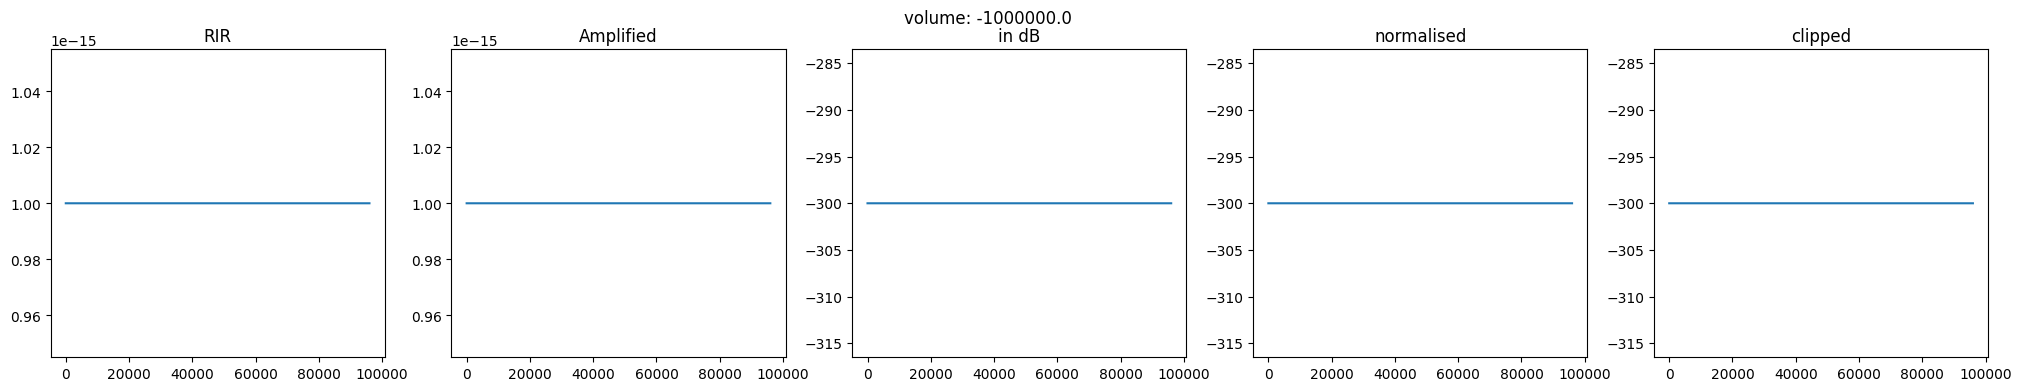

Kx :  tensor([-0.0131])
Ky :  tensor([-0.0152])
Kz :  tensor([-0.0131])
V :  tensor(-1000000.)


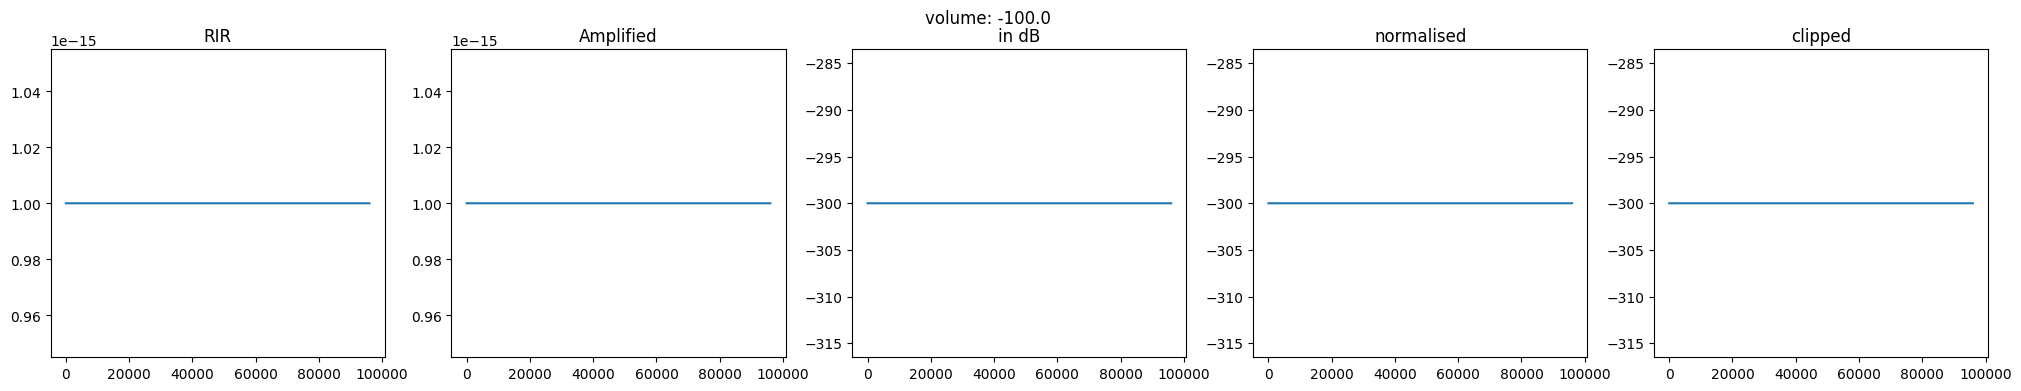

Kx :  tensor([-0.0130])
Ky :  tensor([-0.0162])
Kz :  tensor([-0.0177])
V :  tensor(-100.)


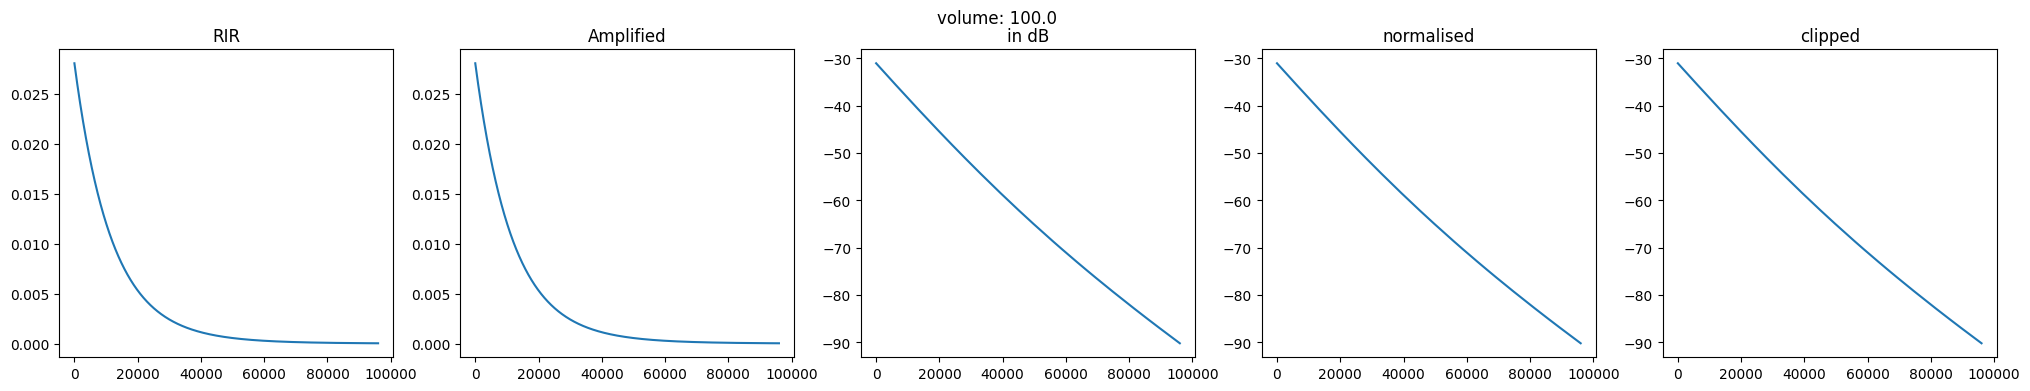

Kx :  tensor([-0.0163])
Ky :  tensor([-0.0197])
Kz :  tensor([-0.0122])
V :  tensor(100.)


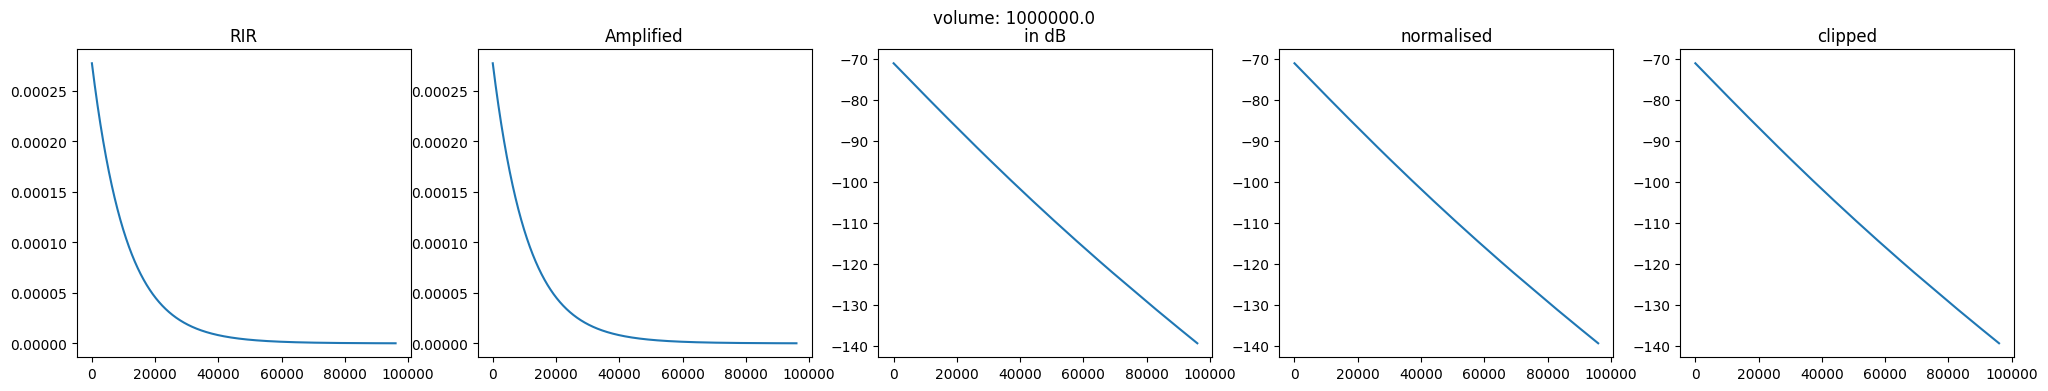

Kx :  tensor([-0.0171])
Ky :  tensor([-0.0190])
Kz :  tensor([-0.0160])
V :  tensor(1000000.)


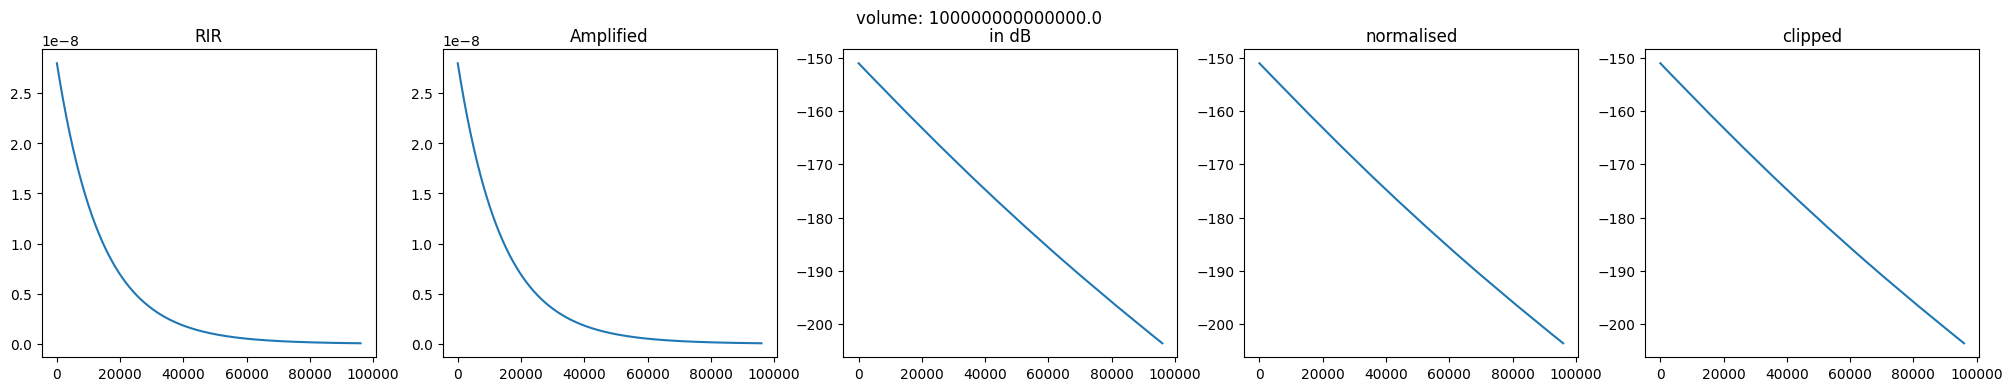

Kx :  tensor([-0.0116])
Ky :  tensor([-0.0122])
Kz :  tensor([-0.0164])
V :  tensor(1.0000e+14)


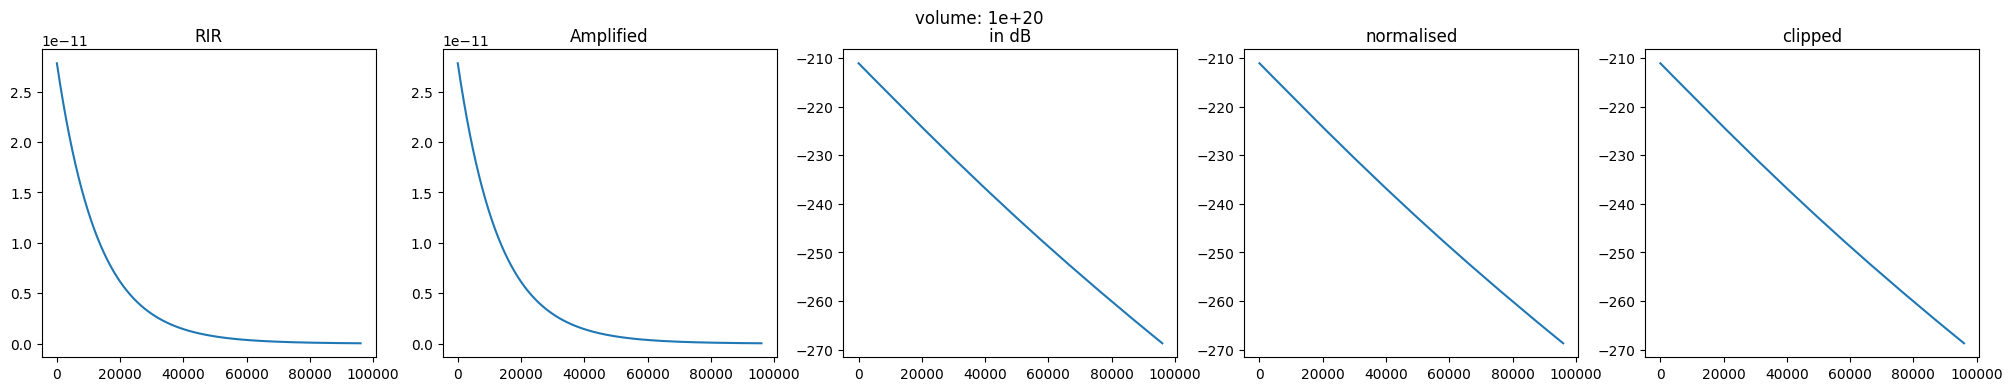

Kx :  tensor([-0.0167])
Ky :  tensor([-0.0134])
Kz :  tensor([-0.0134])
V :  tensor(1.0000e+20)


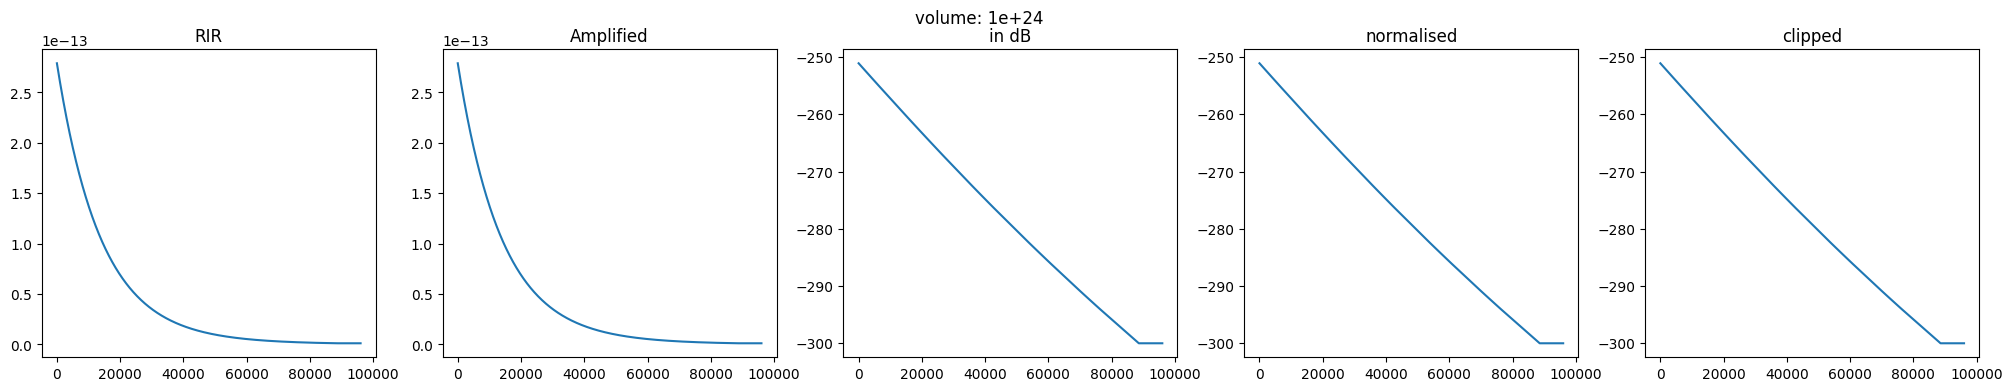

Kx :  tensor([-0.0111])
Ky :  tensor([-0.0131])
Kz :  tensor([-0.0161])
V :  tensor(1.0000e+24)


In [47]:
for v in [-1e+6 ,-1e+2,1e+2, 1e+6, 1e+14, 1e+20, 1e+24]:
    modell = RIR_model(volume=v)
    env_makerF(modell.forward(),normalise = False,clip_=None, display_plots=True, device='cuda',gain=None, title_sup=f"volume: {v}")
    for name, param in modell.named_parameters():
        if param.requires_grad:
            print( name,': ', param.data)

## Helper Funcitons

In [11]:
def mag2db(xcv):
    return 20 * xcv.log10_()

In [12]:
def rir_smoothing(inp, filter_len=2047,device='cpu'):
    ## Main Evelope Block
    filter_= torch.ones(filter_len).to(device=device)
    filter_avg = filter_/torch.sum(filter_) # Avg filter
    sqq = inp**2    # Squaring for Power
    # Smoothing 
    smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1,)
    # if smoothed.requires_grad : smoothed.register_hook(lambda x : print("smoothed: ",x[-10:], smoothed.grad_fn,smoothed.data[200:210], torch.any(torch.isnan(x))))
    return smoothed

In [13]:
def env_makerF(inp,  gain=None, clip_=None, normalise=False, title_str = '', title_sup = '', display_plots=False, device='cpu'):
    #eps=2.2204e-20
    # Amplify
    # if inp.requires_grad : inp.register_hook(lambda x : print("env_inp: ", x[200:210],inp.grad_fn,inp.data[200:210], torch.any(torch.isnan(x))))
    if gain is not None:
        arr = inp * (10**(gain/20))
    else:
        arr = inp
    # if arr.requires_grad : arr.register_hook(lambda x : print("arr: ",x[200:210], arr.grad_fn,arr.data[200:210],torch.any(torch.isnan(x))))
    # ## Main Evelope Block
    # filter_= torch.ones(filter_len).to(device=device)
    # filter_avg = filter_/torch.sum(filter_) # Avg filter
    # sqq = arr**2    # Squaring for Power
    # # Smoothing 
    # smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1,)
    # if smoothed.requires_grad : smoothed.register_hook(lambda x : print("smoothed: ",x[-10:], smoothed.grad_fn,smoothed.data[200:210], torch.any(torch.isnan(x))))
    sm2 = arr.clone() + eps
    # if sm2.requires_grad : sm2.register_hook(lambda x : print("sm2: ", x[-10:], sm2.grad_fn,sm2.data, torch.any(torch.isnan(x))))
    # if torch.any(sm2<=0) : print("negative in sm2",[it for it in sm2 if it<=0])
    in_db = mag2db(sm2)    # Convert to dB scale
    #if in_db.requires_grad : in_db.register_hook(lambda x : print("in_db: ", x,in_db.grad_fn,in_db.data, torch.any(torch.isnan(x))))

    # Clipping below -150/-100dB
    # if clip_ is not None:
    #     in_db2 = torch.clip(in_db, min=clip_)
    # else:
    #     in_db2 = in_db

    # normalise around zero
    if normalise:
        normalised = in_db - torch.mean(in_db)
    else:
        normalised = in_db
    #if normalised.requires_grad : normalised.register_hook(lambda x : print("normalised: ", x[:10], normalised.grad_fn,normalised.data[:10], torch.any(torch.isnan(x))))
    # Clipping below -150/-100dB
    if clip_ is not None:
        clipped_db = torch.clip(normalised, min=clip_)
    else:
        clipped_db = normalised
    # Plot   
    if display_plots:
        # if title_str == '':
        #     title_str = str(filter_len)
        title_switch = {
        1: "RIR",
        # 2: "Squared RIR",
        2: "Amplified",
        3: "in dB", 
        4: "normalised" ,
        5: "clipped"}
        if device == 'cuda':
            normalised_c = normalised.clone()
            llist = [inp.detach().cpu(), arr.detach().cpu(),in_db.detach().cpu(),normalised_c.detach().cpu(),clipped_db.detach().cpu()]
        else:
            llist = [inp, arr, clipped_db, normalised]
        #
        plt.figure(figsize=(25,4))
        for i, it in enumerate(llist):
            plt.subplot(1,5, i+1)
            plt.plot(it)
            plt.title(title_switch[i+1]) #Filter: "+title_str)
            if title_sup != '':
                plt.suptitle(title_sup)
        plt.show()
    
    return normalised

In [14]:
def rir_bands(rir, f_center=None, fs=16000, device='cpu'):
# separate RIR into Frequenc bands
    if not f_center:
        nBands = 6
        f_center = torch.zeros(nBands).to(device=device)
        f_center[0] = 125.0     # lowest octave band
        for it in range(1, nBands):
            f_center[it] =  2.0 * f_center[it-1]
    else:
        nBands = f_center.size(0)

    if nBands == 1:
        return rir
    else:
        # order of filters
        order = 1000
        filters = torch.zeros(order + 1, nBands).to(device=device)

        for i in range(nBands):
            if i == 0:
                fl = 30
                fh = (f_center[i] * f_center[i + 1]).sqrt()
                w = torch.tensor([fl / (fs / 2), fh / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='bandpass',  idx = i, device=device)
            elif i == nBands - 1:
                fl = (f_center[i] * f_center[i - 1]).sqrt()
                w = torch.tensor([fl / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='highpass',idx = i, device=device)
            else:
                fl = (f_center[i] * f_center[i - 1]).sqrt()
                fh = (f_center[i] * f_center[i + 1]).sqrt()
                w = torch.tensor([fl / (fs / 2), fh / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='bandpass',  idx = i, device=device)
        # padding
        temp_rir = torch.cat([rir, torch.zeros(order).to(device=device)])

        #plot filters
        # plt.figure(4, figsize=(15,4))
        # for it in range(filters.size(1)):
        #     plt.subplot(2,3,it+1)
        #     plt.plot(filters[:,it])

        rir_filt = torch.zeros(rir.size(0)).to(device=device)
        for j in range(nBands):
            xy = torch.nn.functional.conv1d(temp_rir.reshape(1, -1), filters[:, j].reshape(1,1,-1), stride=1, padding='valid', bias=None).squeeze()
            rir_filt = torch.vstack((rir_filt, xy))

        rir_filt = rir_filt[1:,:].T
            
        return rir_filt

In [63]:
# calculate Damping Coefficients, K Values, and Del_K values
def calculate_K(betas_a, lengths_a):
    ''' 
    betas: a 6x1 array of all reflection coefficients
    lengths: 3x1 array of all wall measurements
    '''
    betas = torch.sort(betas_a)[0]
    lengths = torch.sort(lengths_a)[0]
    print(betas,lengths)
    Kx = torch.log(torch.prod(betas[0:2])) / lengths[0]
    Ky = torch.log(torch.prod(betas[2:4])) / lengths[1]
    Kz = torch.log(torch.prod(betas[4:6])) / lengths[2]
    return Kx, Ky, Kz

# Calculate del K values
def calculate_del_K(Kx, Ky, Kz):
    kes = torch.sort(torch.cat([Kx.view(-1), Ky.view(-1), Kz.view(-1)]))[0]
    return kes[0], kes[1] - kes[0], kes[2] - kes[1]

def calculate_K_from_del(del_Kx, del_Ky, del_Kz):
    return [del_Kx, del_Kx + del_Ky, del_Kz + del_Ky + del_Kx]

## Training

---------------- Datapoint number: 1 out of 5 ----------------
tensor([0.3900, 0.5500, 0.6200, 0.8300, 0.8900, 0.9000]) tensor([4.7000, 6.4000, 7.1000])
Target Kvalues: tensor([-0.3275, -0.1038, -0.0313], device='cuda:0'), targel Volume: 213.56797790527344 


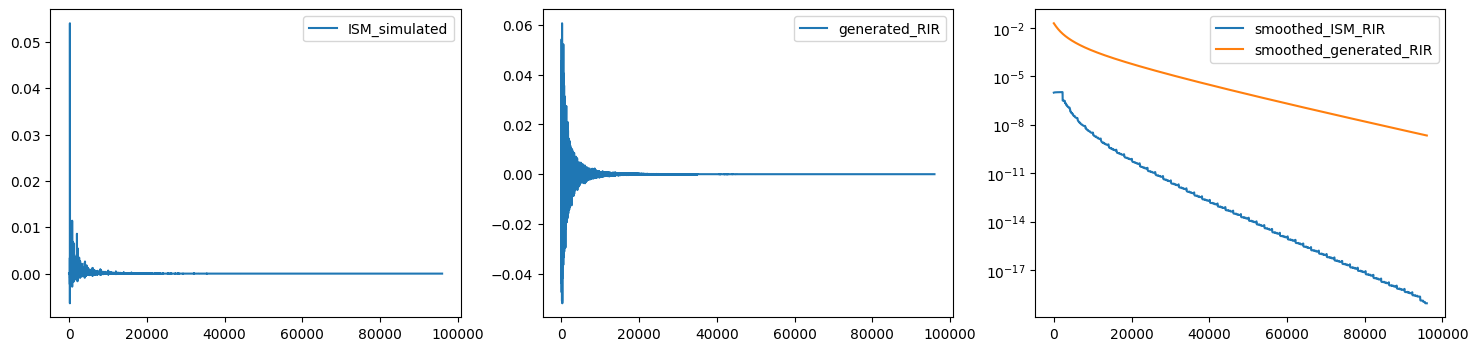

---------------- Datapoint number: 2 out of 5 ----------------
tensor([0.1500, 0.2600, 0.3300, 0.5900, 0.7800, 0.9000]) tensor([4.9000, 6.0000, 7.7000])
Target Kvalues: tensor([-0.6621, -0.2727, -0.0460], device='cuda:0'), targel Volume: 226.37998962402344 


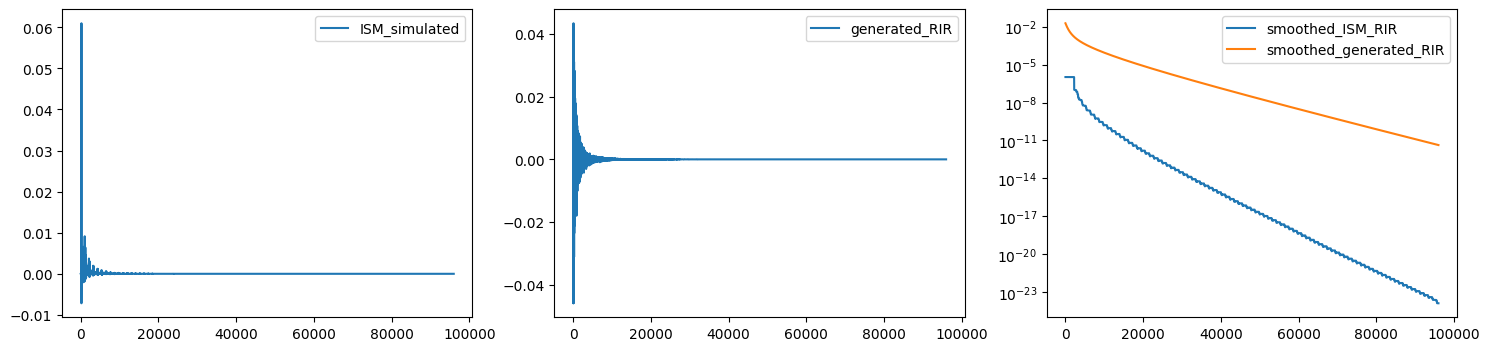

---------------- Datapoint number: 3 out of 5 ----------------
tensor([0.3100, 0.5700, 0.7700, 0.8300, 0.8400, 0.8600]) tensor([5.7000, 7.8000, 7.9000])
Target Kvalues: tensor([-0.3041, -0.0574, -0.0412], device='cuda:0'), targel Volume: 351.2340087890625 


KeyboardInterrupt: 

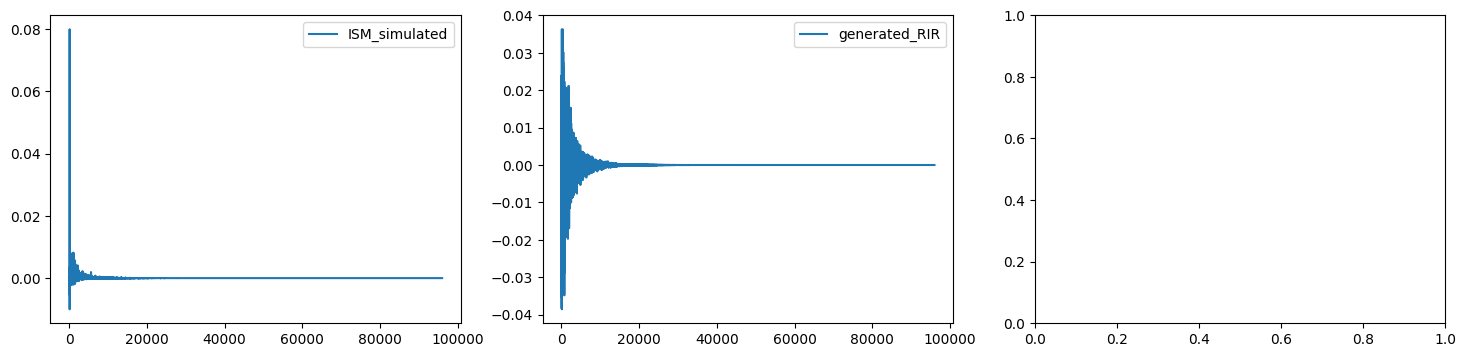

In [96]:
device = 'cuda'
env_filter_len = 4095
# data 
rir_data = torch.tensor(rir_np[:5, :], dtype=torch.float)#.to(device=device)

for i in range(rir_data.size(0)):
    print(f"---------------- Datapoint number: {i+1} out of {rir_data.size(0)} ----------------")

    lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:]
    #labels = rir_bands(rir_.to(device=device), device=device)
    target_K_values = torch.tensor(np.sort(np.array(calculate_K(betas, lengths)))).to(device=device)
    t_vol = torch.prod(lengths)
    print(f"Target Kvalues: {target_K_values}, targel Volume: {t_vol} ")
    
    #l_smoothee = rir_.to(device=device)
    l_smoothee = rir_smoothing(rir_.to(device=device), filter_len=env_filter_len , device=device)
    h, env = generate_stochastic_rir(Kx=target_K_values[0], Ky=target_K_values[1], Kz=target_K_values[2],  V=t_vol, device=device)
    plt.figure(i+j+1, figsize=(18,4))
    plt.subplot(1,3,1)
    plt.plot(rir_.cpu(), label = 'ISM_simulated')
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(h.cpu(), label='generated_RIR')
    #plt.yscale('log')
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(l_smoothee.cpu(), label ='smoothed_ISM_RIR')
    plt.plot(env.cpu(), label ='smoothed_generated_RIR')
    plt.yscale('log')
    plt.legend()
    plt.show()

---------------- Datapoint number: 1 out of 1 ----------------
tensor([0.9000, 0.8900, 0.6200, 0.5500, 0.3900, 0.8300]) tensor([7.1000, 6.4000, 4.7000])
Target Kvalues: tensor([-0.2400, -0.1681, -0.0313], device='cuda:0')
-------- Frequency Band: 1 --------


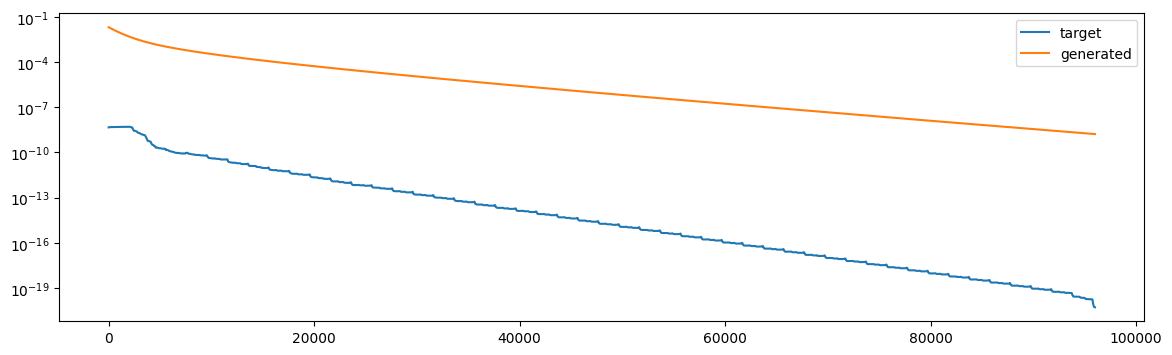

-------- Frequency Band: 2 --------


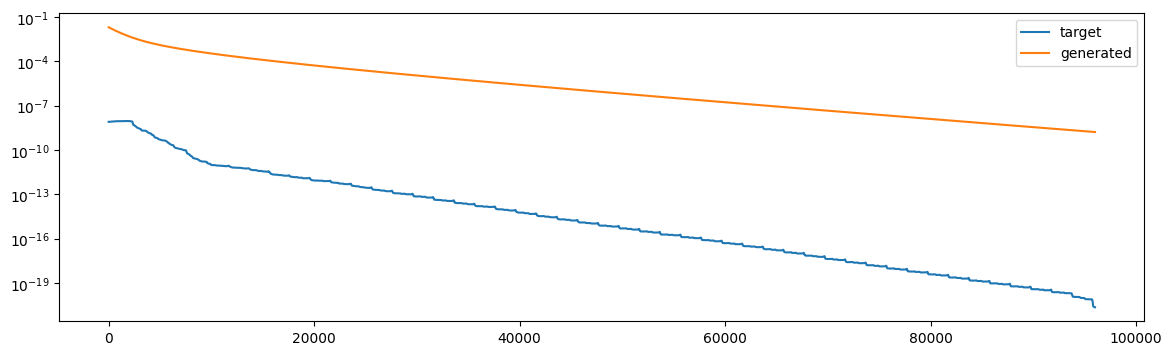

-------- Frequency Band: 3 --------


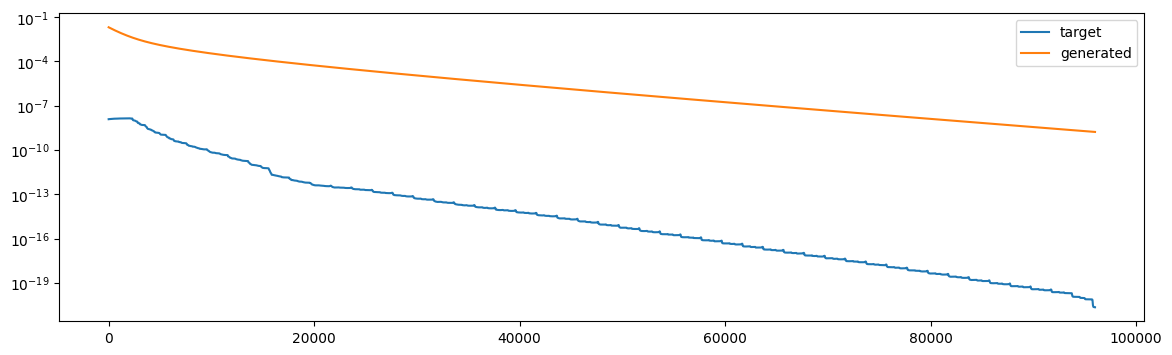

-------- Frequency Band: 4 --------


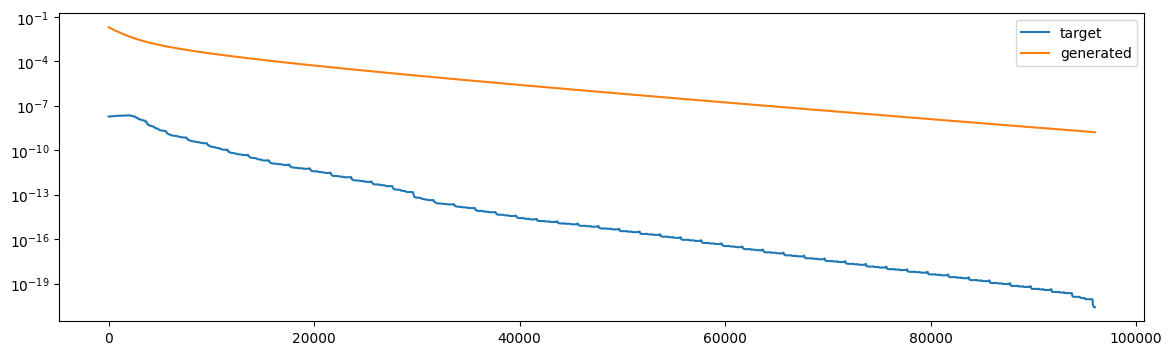

-------- Frequency Band: 5 --------


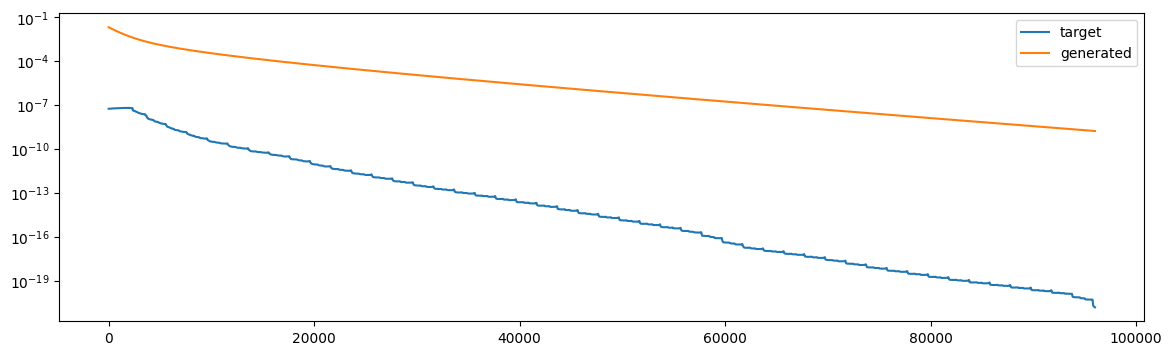

-------- Frequency Band: 6 --------


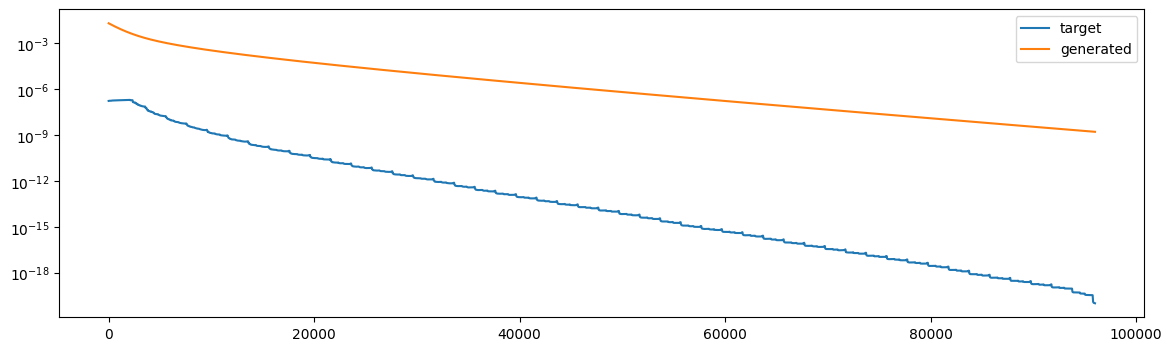

In [58]:
# Simple 
iter_ = 500
lr = 0.000003
env_filter_len = 4095
signal_gain = None    # dB
dB_clip = None
normalize = False
model_used = RIR_model
device = 'cuda'
logging_frequency = 50     # epochs  
stopping_criterion = 200 
max_time = 2.0

# data 
rir_data = torch.tensor(rir_np[:1, :], dtype=torch.float)#.to(device=device)
known_data = True
# rir_data = torch.tensor(rir_real[4:7, :], dtype=torch.float).to(device=device)

for i in range(rir_data.size(0)):
    print(f"---------------- Datapoint number: {i+1} out of {rir_data.size(0)} ----------------")
    if known_data:
        # for generated data
        lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:]
        labels = rir_bands(rir_.to(device=device), device=device)
        target_K_values = torch.tensor(np.sort(np.array(calculate_K(betas, lengths)))).to(device=device)
        print(f"Target Kvalues: {target_K_values}")
    else:
        # for real world data 
        labels = rir_bands(rir_data[i, :].to(device=device), device=device)

    nBands = labels.size(1)
    for j in range(nBands):
        # for each frequency band
        print(f"-------- Frequency Band: {j+1} --------")
        # create label envelope
        #l_env = env_makerF(rir_smoothing(labels[:, j], filter_len=env_filter_len , device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize, device=device, display_plots=False)
        l_smooth = rir_smoothing(labels[:, j], filter_len=env_filter_len , device=device)
# check validity of code
        #print(target_K_values, lengths)
        gen = generate_stochastic_rir(Kx=target_K_values[0], Ky=target_K_values[1], Kz=target_K_values[2],  V=torch.prod(lengths), max_time=maxTime, device=device)
        plt.figure(i+j+1, figsize=(14,4))
        plt.plot(l_smooth.cpu(), label = 'target')
        plt.plot(gen.cpu(), label='generated')
        plt.yscale('log')
        plt.legend()
        plt.show()


# normal part
        # mod = model_used(device=device).to(device=device)
        # crit = torch.nn.L1Loss(reduction='mean').to(device=device)
        # optim = torch.optim.SGD(mod.parameters(),lr=lr, momentum=0.9)
        # # Save Initial model parameters
        # print("\nInitial model Params:")
        # init_param_dict = {}
        # for name, param in mod.named_parameters():
        #     if param.requires_grad:
        #         print( name,': ', param.data)
        #         init_param_dict.update({name:param.data.clone()})
        # # Start Optimizytion
        # t_l = []    # array to save training loss
        # #early_stopping = 0  # early stopping counter
        # #min_loss = torch.inf    # minimum loss, set to inf 
        # print("\nOptimization process starts:")
        # for it in range(iter_):
        #     optim.zero_grad()
        #     # model forward
        #     y_hat = mod.forward()
        #     x_env = env_makerF(y_hat, gain=signal_gain, clip_=dB_clip, normalise=normalize, device=device)
        #     # loss calculate
        #     l = crit(x_env, l_env)
        #     l.backward()
        #     optim.step()
        #     t_l.append(l.clone().detach().cpu())
        #     if it%logging_frequency == 0 : 
        #         print(f'Loss in epoch:{it} is : {np.round(np.float64(l.clone().detach()), decimals=4)}')
        #     # # early stopping
        #     # if early_stopping > stopping_criterion: 
        #     #     print('Break: Early Stopping')
        #     #     break
        
        # # save model param after optimization
        # print("\nUpdated Param after Trial:")
        # for name, param in mod.named_parameters():
        #     if param.requires_grad:
        #         print( name,': ', param.data)
        # # plot
        # plt.figure(i+j+1, figsize=(14,4))
        # plt.suptitle(f" IR:{i+1}, fBand:{j+1}")#, minLoss:{min_loss}dB")
        # plt.subplot(1,2,1)
        # plt.plot(t_l,)
        # plt.ylabel('loss value in dB')
        # plt.xlabel('Epochs')
        # plt.title("Train Loss")
        # plt.show()
    

---------------- Datapoint number: 1 out of 3 ----------------
-------- Frequency Band: 1 --------

---- Trial number: 1 ---- 

Initial model Params:
del_Kx :  tensor(-0.1752, device='cuda:0')
del_Ky :  tensor(0.0905, device='cuda:0')
del_Kz :  tensor(0.0215, device='cuda:0')
V :  tensor([37.7000], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 105.7518
Loss in epoch:50 is : 41.1824
Loss in epoch:100 is : 41.1824
Loss in epoch:150 is : 41.1824
Loss in epoch:200 is : 41.1824
Loss in epoch:250 is : 41.1824
Loss in epoch:300 is : 41.1824
Loss in epoch:350 is : 41.1824
Loss in epoch:400 is : 41.1824
Loss in epoch:450 is : 41.1824
Loss in epoch:500 is : 41.1824
Loss in epoch:550 is : 41.1824
Loss in epoch:600 is : 41.1824
Break: Early Stopping
Give Up

Updated Param after Trial:
del_Kx :  tensor(-0.7294, device='cuda:0')
del_Ky :  tensor(-0.4393, device='cuda:0')
del_Kz :  tensor(-0.4242, device='cuda:0')
V :  tensor([-3.0000e+31], device='cuda:0')
Final model params fo

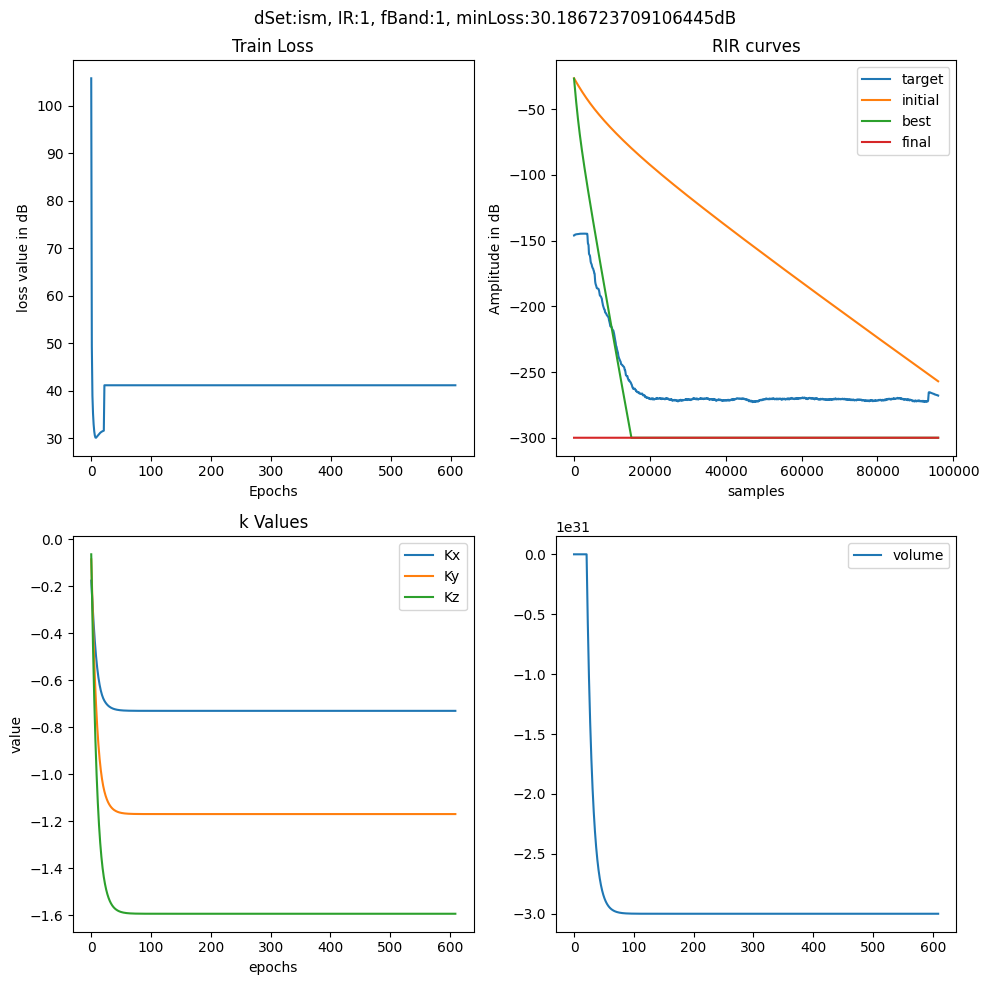

-------- Frequency Band: 2 --------

---- Trial number: 1 ---- 

Initial model Params:
del_Kx :  tensor(-0.1888, device='cuda:0')
del_Ky :  tensor(0.0318, device='cuda:0')
del_Kz :  tensor(0.1429, device='cuda:0')
V :  tensor([158.7000], device='cuda:0')

Optimization process starts:
Loss in epoch:0 is : 178.7311
Loss in epoch:50 is : 30.9494
Loss in epoch:100 is : 30.9494
Loss in epoch:150 is : 30.9494
Loss in epoch:200 is : 30.9494
Loss in epoch:250 is : 30.9494
Loss in epoch:300 is : 30.9494
Loss in epoch:350 is : 30.9494
Loss in epoch:400 is : 30.9494
Loss in epoch:450 is : 30.9494
Loss in epoch:500 is : 30.9494
Loss in epoch:550 is : 30.9494
Loss in epoch:600 is : 30.9494
Break: Early Stopping
Give Up

Updated Param after Trial:
del_Kx :  tensor(-0.7628, device='cuda:0')
del_Ky :  tensor(-0.5205, device='cuda:0')
del_Kz :  tensor(-0.3933, device='cuda:0')
V :  tensor([-3.0000e+31], device='cuda:0')
Final model params for band-2: {'del_Kx': tensor(-0.4193), 'del_Ky': tensor(-0.1870

KeyboardInterrupt: 

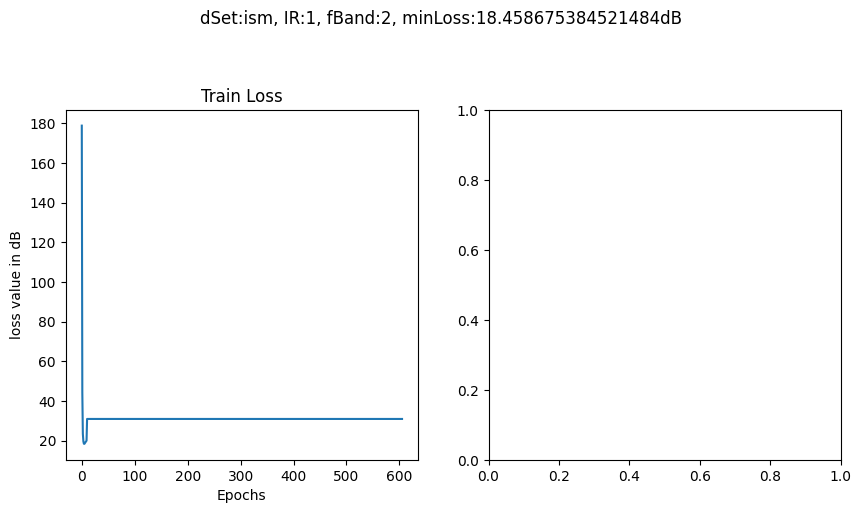

In [88]:
# Real RIR training - add noise2/8-level - Del model- Frequency Dependent case
# hyper params
iter_ = 1500
lr = 0.00003
env_filter_len = 4095
signal_gain = None    # dB
dB_clip = None
normalize = False
model_used = RIR_model_del
# params
device = 'cuda'
logging_frequency = 50     # epochs  
stopping_criterion = 600   # epochs \ must be < 0.5* iter
accepted_loss = 3#20 #3    # good enough loss to stop searching     # dB
good_loss = 2 #10 #2    # minimum loss required - loss lower than this is arbitrary
converging_loss = 10#50    # maximum accepted loss
convergence_trials = 1
lossUpdate_thresh = 0.05
env_st = 0    # 
maxTime = (96000-env_st)/48000
randW_eps = 1e-1
# For real RIR
dName = 'ism'
# rir_data = torch.tensor(rir_np[:6, :], dtype=torch.float)#.to(device=device)
known_data = False
rir_data = torch.tensor(rir_real[4:7, :], dtype=torch.float).to(device=device)
label_names = ['Kx', 'Ky', 'Kz', 'Vol', 'Noise',  'Convergence', 'Min_loss']
#
rir_convergence_Counter = 0
rir_notConverged_memory = []
for i in range(rir_data.size(0)):
    print(f"---------------- Datapoint number: {i+1} out of {rir_data.size(0)} ----------------")
    if known_data:
        # for generated data
        lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:]
        labels = rir_bands(rir_.to(device=device), device=device)
        target_K_values = np.sort(np.array(calculate_K(betas, lengths)))
        print(f"Target Kvalues: {target_K_values}")
    else:
        # for real world data 
        labels = rir_bands(rir_data[i, :].to(device=device), device=device)
    # define counters and storage arrays
    #print(labels.size())
    nBands = labels.size(1)
    k_array = torch.zeros((nBands, 6))#.to(device=device)    # store K values for all bands
    band_convergence_counter = 0
    band_convergence_counter2 = 0
    band_giveUp_counter = 0
    #
    for j in range(nBands):
        # for each frequency band
        print(f"-------- Frequency Band: {j+1} --------")
        # create label envelope
        l_env = env_makerF(rir_smoothing(labels[:, j], filter_len=env_filter_len , device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device, display_plots=False)
        #
        not_converged  = True
        convergence_flag = False
        giveUp_flag = False
        converge_counter = 0
        best_param_dict = {}
        global_loss = torch.inf
        param_plot_dict = { }
        while not_converged:
            bbest_param_dict = {}
            converge_counter += 1
            param_plot_dict = { }
            print(f"\n---- Trial number: {converge_counter} ---- ")
            # Initialization
            mod = model_used(max_time=maxTime, device=device).to(device=device)
            # crit = torch.nn.SmoothL1Loss(reduction='mean', beta=2.0).to(device=device)
            # crit = torch.nn.HuberLoss(reduction='mean', delta=3.0).to(device=device)
            crit = torch.nn.L1Loss(reduction='mean').to(device=device)
            optim = torch.optim.SGD(mod.parameters(),lr=lr, momentum=0.9)
            #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.9, patience=50)
            init_param_dict = {}
            print("\nInitial model Params:")
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    print( name,': ', param.data)
                    init_param_dict.update({name:param.data.clone()})
                    param_plot_dict.update({ name : [param.data.clone().cpu().numpy()]})
            # plt.figure(989+i*j, figsize=(5,4))
            # plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=init_param_dict['del_Kx'], del_Ky=init_param_dict['del_Ky'], del_Kz=init_param_dict['del_Kz'], noise_level=init_param_dict['noise_level'],  device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            # plt.title('Initial')
            # plt.show()
            # Gradient descent
            t_l = []
            early_stopping = 0
            min_loss = torch.inf
            print("\nOptimization process starts:")
            for it in range(iter_):
                optim.zero_grad()
                y_hat = mod.forward()
                #x_env = env_makerF(y_hat, filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize, device=device)
                x_env = env_makerF(y_hat, gain=signal_gain, clip_=dB_clip, normalise=normalize, device=device)
                #if x_env.requires_grad : x_env.register_hook(lambda x : print("x_env: ", x,x_env.grad_fn,x_env.data, torch.any(torch.isnan(x))))
                # random weighting
                random_W = torch.FloatTensor(96000 - env_st).uniform_(1-randW_eps, 1+randW_eps).to(device=device)
                #l = crit(x_env*random_W, l_env*random_W)
                l = crit(x_env, l_env[env_st:])
                #l = torch.mean(torch.abs(x_env - l_env)*random_W)
                #l = torch.sqrt(torch.clamp(torch.mean(torch.square(x_env - l_env)*torch.square(random_W)), min=0.0000001))
                #if torch.isnan(l): break
                l.backward()
                optim.step()
                #scheduler.step(l)
                log_l = l.clone().detach().cpu()
                t_l.append(log_l)
                # plot k values
                for name, param in mod.named_parameters():
                    if param.requires_grad:
                        param_plot_dict[name].append(param.data.clone().cpu().numpy())
                # early stopping
                # early stopping for convergent cases
                #if log_l < min_loss:
                if min_loss - log_l > lossUpdate_thresh:
                    early_stopping = 0
                    min_loss = log_l
                    # save params
                    bbest_param_dict.update({'min_loss': min_loss})
                    for name, param in mod.named_parameters():
                        if param.requires_grad:
                            bbest_param_dict.update({name: param.data.clone()})
                else:
                    early_stopping += 1    
                
                
                if it%logging_frequency == 0 : 
                    print(f'Loss in epoch:{it} is : {np.round(np.float64(l.detach()), decimals=4)}')
                    # plt.figure((it+1)*547, figsize=(10,4))
                    # plt.subplot(1,2,1)
                    # plt.plot(y_hat.clone().detach().cpu(), label='model')
                    # plt.plot(rir_smoothing(labels[:, j], filter_len=env_filter_len , device=device).cpu(), label="target")
                    # plt.yscale("log")
                    # plt.legend()
                    # plt.subplot(1,2,2)
                    # plt.plot(x_env.clone().detach().cpu(), label='model_env')
                    # plt.plot(l_env.clone().detach().cpu(), label='target')
                    # plt.legend()
                    # plt.show()
                
                if early_stopping > stopping_criterion: 
                    print('Break: Early Stopping')
                    break
                if min_loss < good_loss:
                    print('Break: Good enough loss')
                    break
            # converge case
            if min_loss < accepted_loss: 
                print("converged!")
                not_converged=False   
                band_convergence_counter += 1
                convergence_flag = True  
            elif converge_counter >= convergence_trials: 
                # tried but not converged
                print("Give Up")
                not_converged=False
                band_giveUp_counter += 1
                giveUp_flag = True
            
            # check global convergence among trials
            if min_loss < global_loss:
                global_loss = min_loss
                best_param_dict = bbest_param_dict
            
            print("\nUpdated Param after Trial:")
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    print( name,': ', param.data)
            

        #print(f"\nFinal Updated model Params:")
        final_param_collector = {} #torch.zeros((1)).to(device=device)
        #print("best", best_param_dict)
        
        if giveUp_flag:
            if global_loss < converging_loss:
                print("\nconverged 2!")
                band_convergence_counter += 1
                band_convergence_counter2 += 1
                convergence_flag = True
            # take the best 
            #print("best params:", best_param_dict)
            for key in best_param_dict:
                    if key == 'min_loss':
                        continue
                    else:
                        final_param_collector.update({key: best_param_dict[key].detach().cpu()})
            #final_param_collector = torch.concat((final_param_collector, best_param_dict['del_Kx'].view(-1), best_param_dict['del_Ky'].view(-1), best_param_dict['del_Kz'].view(-1)))
        else:
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    #print( name,': ', param.data)
                    #final_param_collector = torch.concat((final_param_collector, param.data.view(-1)))
                    final_param_collector.update({name: param.data.detach().cpu()})
        
            
        #final_param_collector = final_param_collector[1:]
        #print(f"\nMin Loss: {np.round(np.float64(best_param_dict['min_loss']), decimals=2)} in dB")
        print(f"Final model params for band-{j+1}: {final_param_collector}")
        final_param_tensor = list(final_param_collector.values())
        print("final param", final_param_tensor)
        # final_param_tensor.append(convergence_flag)
        # final_param_tensor.append(best_param_dict['min_loss'])
        # k_array[j, :] = torch.tensor(final_param_tensor)
        # final_K_values = calculate_K_from_del(final_param_tensor[0], final_param_tensor[1], final_param_tensor[1])
        # print(f"Final K values: Kx: {final_K_values[0]}, Ky: {final_K_values[1]}, Kz: {final_K_values[2]}")
        ###
        if model_used == RIR_model_del:
            final_K_values = calculate_K_from_del(final_param_tensor[0], final_param_tensor[1], final_param_tensor[2])
            print(f"\nFinal K values: Kx: {np.round(np.float64(final_K_values[0]), 4)}, Ky: {np.round(np.float64(final_K_values[1]), 4)}, Kz: {np.round(np.float64(final_K_values[2]), 4)}")
            final_K_values.append(final_param_tensor[3])
            # plot K value part
            kValue_plot_dict = {'Kx':[],'Ky':[], 'Kz':[], 'V':[]}
            dKeys = list(param_plot_dict.keys())
            print("dkeyss", dKeys)
            for ik in range(len(param_plot_dict[dKeys[0]])):
                Kx, Ky, Kz = calculate_K_from_del(param_plot_dict[dKeys[0]][ik], param_plot_dict[dKeys[1]][ik], param_plot_dict[dKeys[2]][ik])
                kValue_plot_dict['Kx'].append(Kx)
                kValue_plot_dict['Ky'].append(Ky)
                kValue_plot_dict['Kz'].append(Kz)
            kValue_plot_dict['V'] = param_plot_dict['V']
        else:
            final_K_values = final_param_tensor
            kValue_plot_dict = param_plot_dict
        final_K_values.append(convergence_flag)
        final_K_values.append(best_param_dict['min_loss'])
        k_array[j, :] = torch.tensor(final_K_values)
        ###
        # 
        
    #   
        # print(param_dict)
        #print("best: ", best_param_dict)
        param_keys = list(kValue_plot_dict.keys())
        model_param_keys = list(init_param_dict.keys())
        print('keys', model_param_keys, param_keys)
        # print('lengths', lengths, torch.prod(lengths))
        plt.figure(i+j+1, figsize=(10,10))
        plt.suptitle(f"dSet:{dName}, IR:{i+1}, fBand:{j+1}, minLoss:{best_param_dict['min_loss']}dB")
        plt.subplot(2,2,1)
        plt.plot(t_l,)# linestyle='', marker='.')
        #plt.hlines(best_param_dict['min_loss'], 0, 96000, label='minLoss', linestyles='dashdot',color='r')
        #plt.ylim([0,100])
        plt.ylabel('loss value in dB')
        plt.xlabel('Epochs')
        plt.title("Train Loss")
        #plt.legend()
        plt.subplot(2,2,2)
        plt.plot(l_env.detach().cpu()[env_st:],  label='target')
        if model_used == RIR_model_del:
            plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=init_param_dict[model_param_keys[0]], del_Ky=init_param_dict[model_param_keys[1]], del_Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=best_param_dict[model_param_keys[0]], del_Ky=best_param_dict[model_param_keys[1]], del_Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='best')
        else:
            plt.plot(env_makerF(generate_stochastic_rir(Kx=init_param_dict[model_param_keys[0]], Ky=init_param_dict[model_param_keys[1]], Kz=init_param_dict[model_param_keys[2]],  V=init_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
            plt.plot(env_makerF(generate_stochastic_rir(Kx=best_param_dict[model_param_keys[0]], Ky=best_param_dict[model_param_keys[1]], Kz=best_param_dict[model_param_keys[2]], V=best_param_dict[model_param_keys[3]], max_time=maxTime, device=device), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='best')
        plt.plot(env_makerF(mod.forward().detach(), gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='final')
        plt.ylabel('Amplitude in dB')
        plt.xlabel('samples')
        plt.title("RIR curves")
        plt.legend()
        plt.subplot(2,2,3)
        plt.plot(kValue_plot_dict[param_keys[0]], label=param_keys[0])
        plt.plot(kValue_plot_dict[param_keys[1]], label=param_keys[1])
        plt.plot(kValue_plot_dict[param_keys[2]], label=param_keys[2])
        if known_data:
            plt.hlines(target_K_values[0], xmin=0, xmax=len(t_l), label='target_Kx', color='r')
            plt.hlines(target_K_values[1], xmin=0, xmax=len(t_l), label='target_Ky', color='k')
            plt.hlines(target_K_values[2], xmin=0, xmax=len(t_l), label='target_Kz', color='m')
        #plt.plot(param_plot_dict[param_keys[3]], label=param_keys[3])    # Noise Level
        plt.ylabel('value')
        plt.xlabel('epochs')
        plt.title("k Values")
        plt.legend()
        plt.subplot(2,2,4)
        plt.plot(kValue_plot_dict[param_keys[3]], label='volume')
        if known_data:
            plt.hlines(torch.prod(lengths),xmin=0, xmax=len(t_l), label='target_volume', color='r' )
        plt.legend()
        # plt.subplot(2,3,5)
        # plt.plot(param_plot_dict['noise_level'])
        rootDir = f"./imgs/{dName}_{str(crit)[:-2]}"
        os.makedirs(rootDir, exist_ok=True)
        fig_fName = f"rir_{i+1}_band_{j+1}.jpg"
        # plt.savefig(os.path.join(rootDir, fig_fName), )
        print('fname:',os.path.join(rootDir, fig_fName))
        plt.tight_layout()
        plt.show()
    print(f"################################### \n K values for all Bands: \n {label_names} \n{k_array}\n Converged for {band_convergence_counter} bands \n ################################### ")
    if band_convergence_counter == 6 : rir_convergence_Counter += 1 
    else : rir_notConverged_memory.append((i, band_convergence_counter, band_convergence_counter2))    # save rir not converged index
print(f"--------------\nTotal Rir converged: {rir_convergence_Counter} out of {rir_data.size(0)} \n Rir not converged: {rir_notConverged_memory}\n--------------")